In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

## Configuration and Spark connection

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("churn_modelling") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

<SparkContext master=local appName=churn_modelling>

## Basic DF operations

In [4]:
spark_df = spark.read.csv("churn.csv",
                           header = True,
                           inferSchema = True,
                           sep = ","
                           )
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [5]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [8]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [ ]:
## rearranging indexes

In [7]:
spark_df = spark_df.withColumnRenamed("_c0","index")
spark_df.show(5)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|    4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [11]:
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
spark_df.show(5)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|    4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [ ]:
## checking unique and null rows

In [12]:
spark_df.count()

900

In [13]:
len(spark_df.columns)

8

In [16]:
spark_df.select("names").distinct().count()

899

In [17]:
distinct_check_df = spark_df.groupby("names")
distinct_check_df.count().sort("count", ascending=False).show(5)

+----------------+-----+
|           names|count|
+----------------+-----+
|   Jennifer Wood|    2|
|    Patrick Bell|    1|
|   Chelsea Marsh|    1|
|Patrick Robinson|    1|
|     John Barber|    1|
+----------------+-----+
only showing top 5 rows



In [18]:
spark_df.filter(spark_df.names=="Jennifer Wood").show()

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [19]:
distinct_df = spark_df.select("names").dropDuplicates().groupby("names").count().sort("count", ascending=False)
distinct_df.groupby("names").count().sort("count", ascending=False).show(3)

+----------------+-----+
|           names|count|
+----------------+-----+
|    Patrick Bell|    1|
|Patrick Robinson|    1|
|   Chelsea Marsh|    1|
+----------------+-----+
only showing top 3 rows



In [20]:
distinct_df.select("names").count()

899

## Exploratory Data Analysis

In [34]:
spark_df.select("age","total_purchase", "account_manager", "years","num_sites","churn").describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [35]:
spark_df.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [36]:
kor_data = spark_df.drop("index","names").toPandas()
kor_data

,age,total_purchase,account_manager,years,num_sites,churn
0,42.0,11066.80,0,7.22,8.0,1
1,41.0,11916.22,0,6.50,11.0,1
2,38.0,12884.75,0,6.67,12.0,1
3,42.0,8010.76,0,6.71,10.0,1
4,37.0,9191.58,0,5.56,9.0,1
...,...,...,...,...,...,...
895,42.0,12800.82,1,3.62,8.0,0
896,52.0,9893.92,0,6.91,7.0,0
897,45.0,12056.18,0,5.46,4.0,0
898,51.0,6517.93,1,5.47,10.0,0


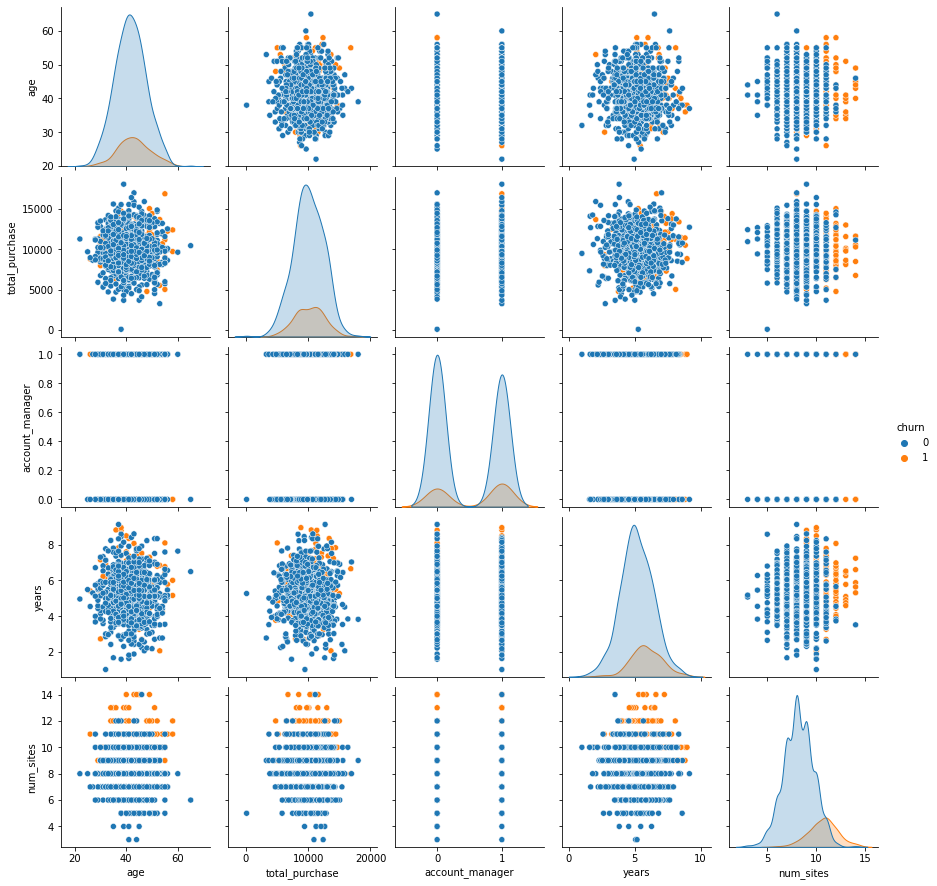

In [37]:
import seaborn as sns
sns.pairplot(kor_data, hue = "churn");

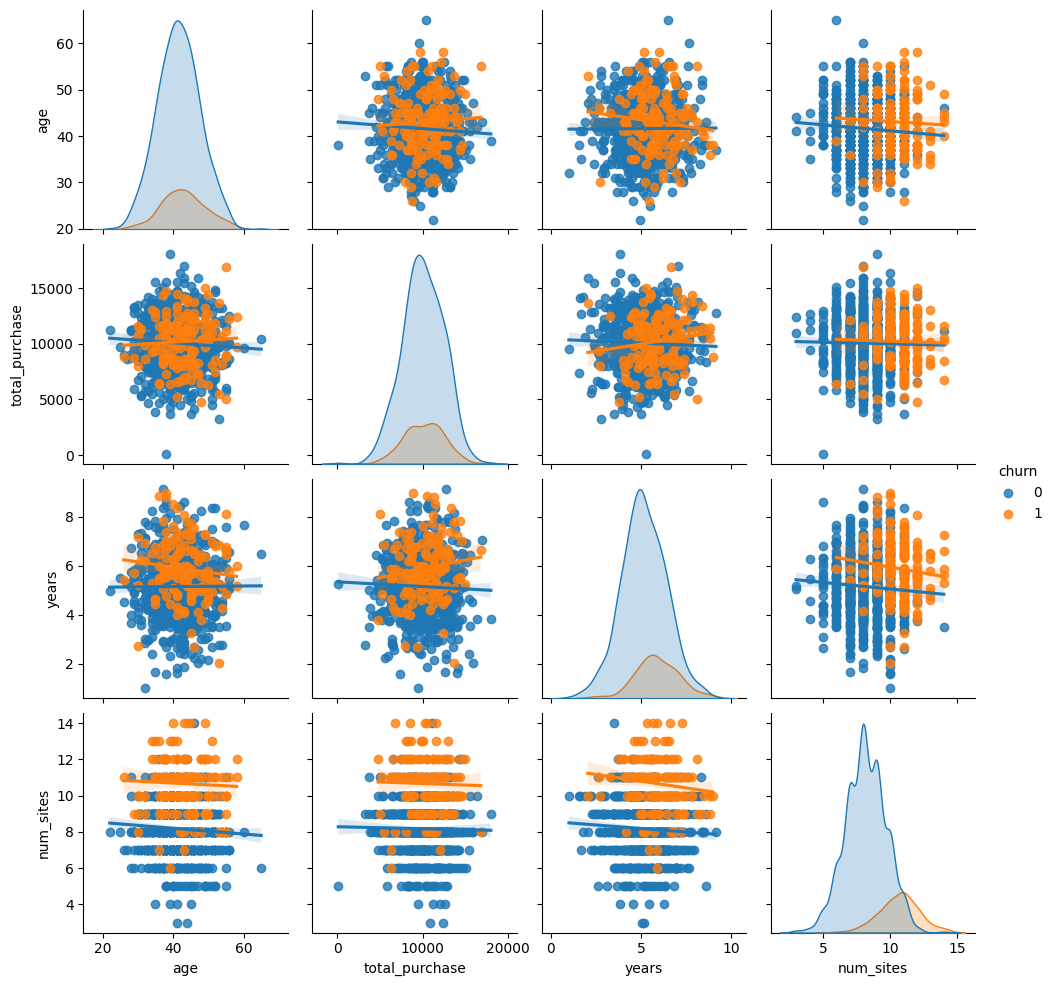

In [38]:
sns.pairplot(kor_data, vars = ["age", "total_purchase","years","num_sites"], 
             hue = "churn",
            kind = "reg");

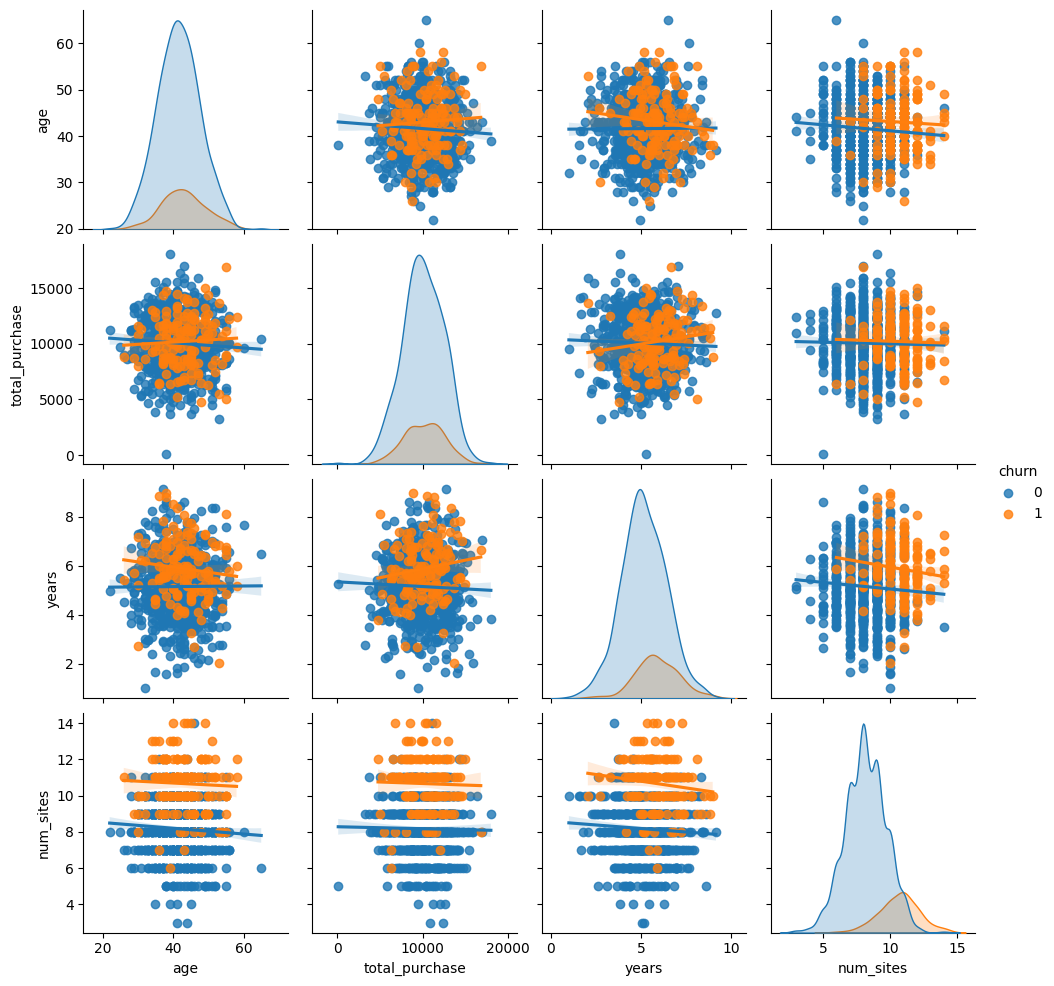

In [39]:
sns.pairplot(kor_data, vars = ["age", "total_purchase","years","num_sites"], 
             hue = "churn",
            kind = "reg");

TypeError: corr() missing 2 required positional arguments: 'col1' and 'col2'